In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.4
Numpy Version:      2.1.1
Scipy Version:      1.14.1
Cython Version:     None
Matplotlib Version: 3.9.2
Python Version:     3.12.5
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/ubuntu-compute/miniconda3/envs/qdev/lib/python3.12/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference ca

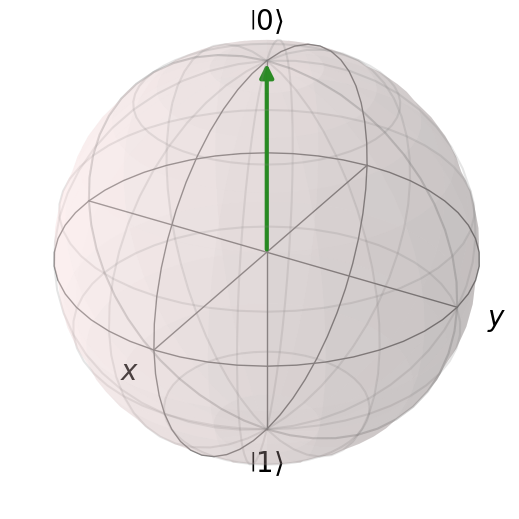

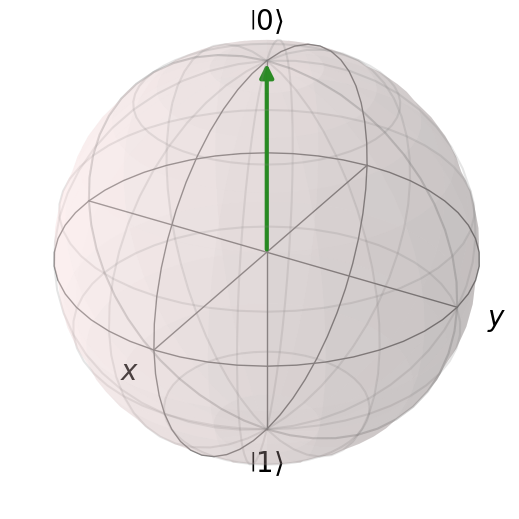

In [6]:
state = qt.basis(2,0)
b = qt.Bloch()
b.add_states(state)
b.title = "Initial state"
b.show()

In [121]:
state1_pops = {}
tlist = np.linspace(0, 50, 500)
sz, sx, sy = qt.sigmaz(), qt.sigmax(), qt.sigmay()
fund_11 = (qt.qeye(2) - sz)/2
fund_01 = (qt.sigmax()+1j*qt.sigmay())/2
fund_10 = (qt.sigmax()-1j*qt.sigmay())/2
def do_sim(Delta_varphi):
    global tlist
    global fund_11
    global fund_01
    global fund_10
    #units
    #hbar = 1
    #[timeunit] = 1e-9 s
    #[frequnit] = 1e9 Hz
    #[energyunit] = 1e9 hbar Hz
    hbar = 1
    psi0 = qt.basis(2,0)
    
    omega_d = 243e-3*2*np.pi
    omega_01 = 243e-3*2*np.pi
    Omega = np.sqrt(2)#*2*np.pi*0.1
    if omega_01 - omega_d == 0:
        H0 = qt.Qobj(0)
    else:
        H0 = qt.QobjEvo([fund_11,(omega_01-omega_d)])*hbar
    H_func = lambda t: -1j*hbar*Omega/4 * (1 + 1j*np.exp(-1j*Delta_varphi)+ np.exp(-2j*omega_d*t)*(1 + 1j*np.exp(1j*Delta_varphi)))
    H1 = qt.QobjEvo([fund_01, H_func])
    H_ = H1.dag()
    H1 = H1 + H_
    if omega_01 - omega_d == 0:
        H = H1
    else:
        H = H0 + H1
    #H = qt.QobjEvo([H0, H1])#), args={omega_d: omega_d, Omega: Omega, Delta_varphi: Delta_varphi})
    
    solver = qt.SESolver(H, options={'nsteps':10000})
    result = solver.run(psi0, tlist)
    #b = qt.Bloch()
    #b.add_states(result.states, kind='point', colors=['b']*len(result.states))
    #b.title = "Delta_varphi = " + str(Delta_varphi)
    #b.show()
    #state1_pops[Delta_varphi] = qt.expect(fund_11, result.states)
    #return qt.expect(fund_11, result.states)
    return result.states

multithread = True

Delta_varphi_space = np.linspace(0, 2*np.pi, 500)
if not multithread:
    for Delta_varphi in Delta_varphi_space:
        state1_pops[Delta_varphi] = do_sim(Delta_varphi)
else:
    from multiprocessing import Pool
    p = Pool(10)
    state1_pops = dict(zip(Delta_varphi_space, p.map(do_sim, Delta_varphi_space))
    )
    p.close()
    p.join()

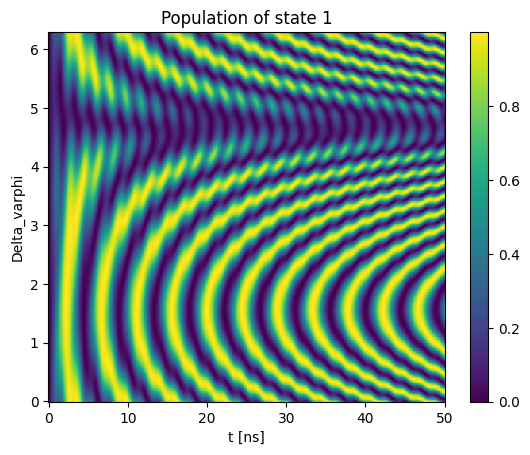

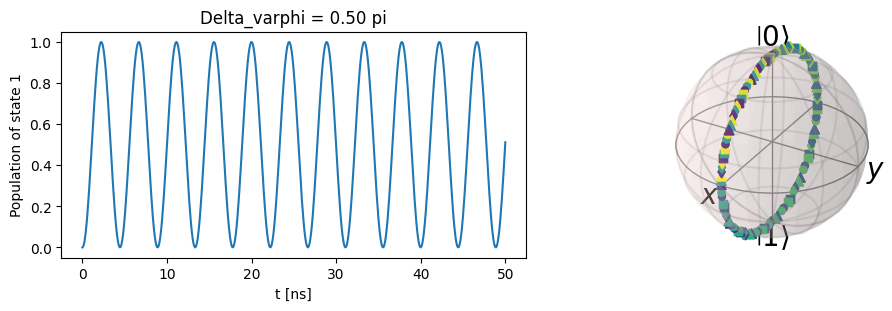

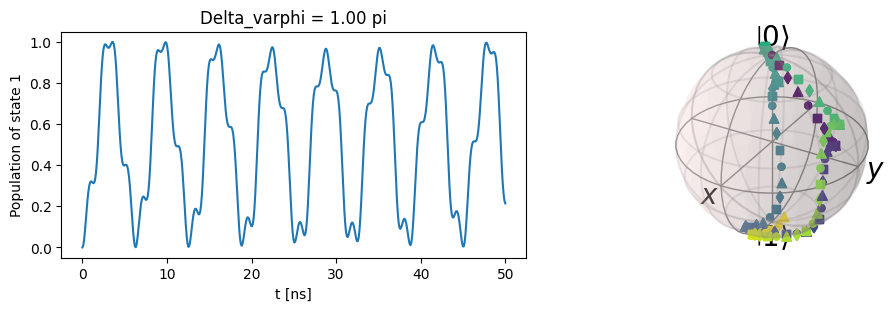

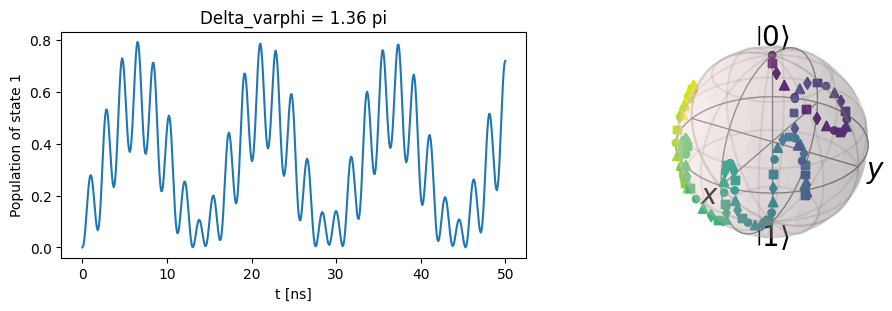

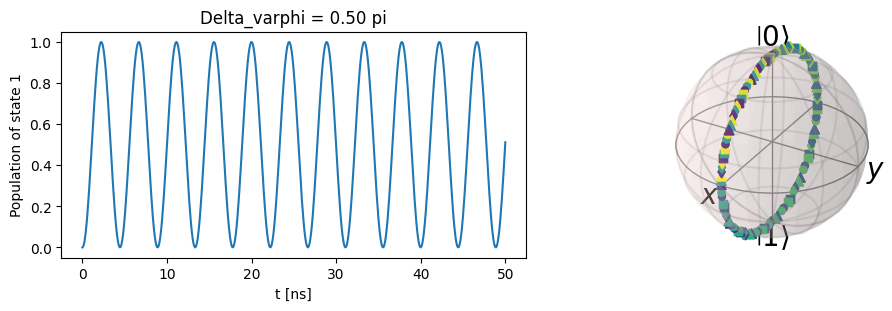

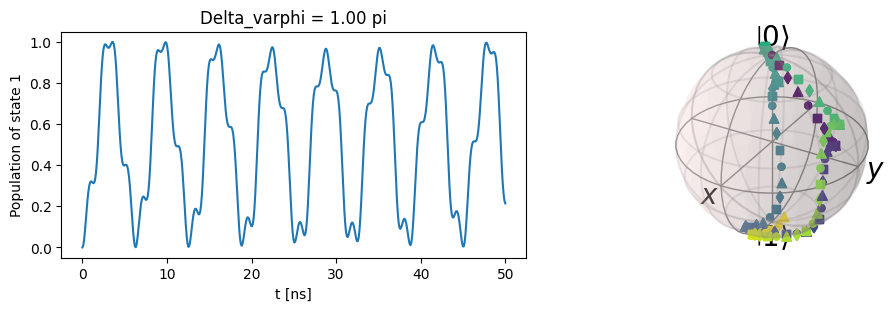

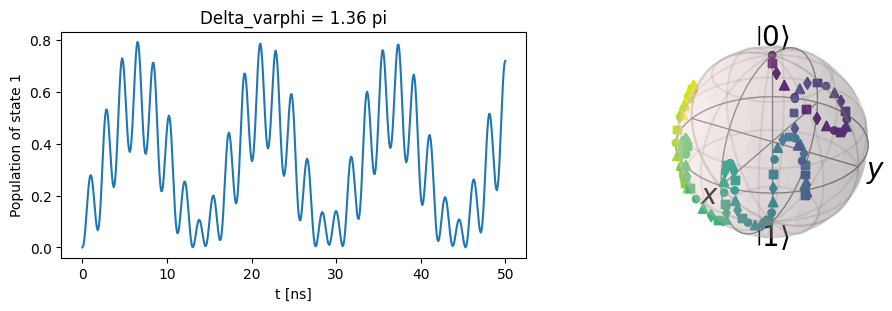

In [122]:
#make image plot with Delta_varphi on y-axis and t on x-axis
cmap = plt.get_cmap('viridis')
#format to array
state1_pops_expectations = {key: qt.expect(fund_11, state1_pops[key]) for key in state1_pops.keys()}
X = np.array(tlist)
Y = np.array(list(state1_pops_expectations.keys()))
X,Y = np.meshgrid(X,Y)
Z = np.array(list(state1_pops_expectations.values()))
plt.pcolormesh(X,Y,Z, cmap=cmap)
plt.colorbar()
plt.xlabel("t [ns]")
plt.ylabel("Delta_varphi")
plt.title("Population of state 1")
plt.show()

#select few values to do a line plot and bloch sphere illustration
for Delta_varphi in [np.pi/2, np.pi, 245*np.pi/180]:
    fig = plt.figure(constrained_layout=True, figsize=(10,3))
    ax1 = fig.add_subplot(121)
    closest_key = min(state1_pops_expectations.keys(), key=lambda x:abs(x-Delta_varphi))
    ax1.plot(tlist, state1_pops_expectations[closest_key])
    ax1.set_xlabel("t [ns]")
    ax1.set_ylabel("Population of state 1")
    ax1.set_title(f"Delta_varphi = {Delta_varphi/np.pi:.2f} pi")

    ax2 = fig.add_subplot(122, projection='3d')
    b = qt.Bloch(fig=fig, axes=ax2)
    #b.render(fig=fig, axes=ax2)
    ax2.set_box_aspect([1,1,1])
    #truncate after 10ns
    index_10ns = np.where(tlist>10)[0][0]
    trunc_pops = state1_pops[closest_key][:index_10ns]
    b.add_states(trunc_pops, kind='point', colors=[cmap(i) for i in np.linspace(0,1,len(trunc_pops))])
    #b.title = f"Delta_varphi = {Delta_varphi/np.pi:.2f} pi"
    b.show()
